In [1]:
import os, sys, inspect
import re
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import matplotlib.pyplot as plt

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 
from utils.data_processing import parse_data, parse_line, create_hierarchy_dict, create_class_levels

## From .hf file

In [2]:
path = "data/imclef07d/imclef07d.hf"

In [3]:
def parse_hierarchy(file_path: str):
    edges = list()
    with open(file_path, "r", newline="\n") as file:
        data = file.readlines()
    for line in data:
        line = line.replace("\n", "")
        edges.append(line.split())
    return edges

In [4]:
edges = parse_hierarchy("data/imclef07d/imclef07d.hf")

In [5]:
vertices = [v for edge in edges for v in edge]
vertices = list(set(vertices))

In [6]:
g = nx.Graph()
g.add_nodes_from(vertices)
g.add_edges_from(edges)

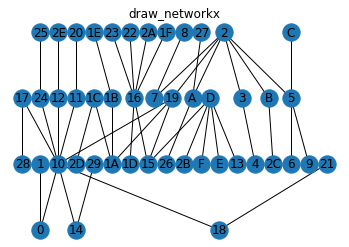

In [7]:
plt.title('draw_networkx')
pos = graphviz_layout(g, prog='dot')
nx.draw(g, pos, with_labels=True, arrows=True)

## Another try

In [8]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 

    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.

    G: the graph (must be a tree)

    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.

    width: horizontal space allocated for this branch - avoids overlap with other branches

    vert_gap: gap between levels of hierarchy

    vert_loc: vertical location of root

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos


    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

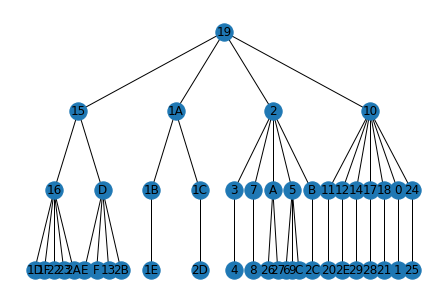

In [9]:
# g = nx.from_pandas_edgelist(df_edges)
pos = hierarchy_pos(g, '19')    # 19 is root
nx.draw(g, pos, with_labels=True, arrows=True)

In [10]:
children, parents = create_hierarchy_dict(edges)

In [11]:
children

{'0': ['1'],
 '2': ['3', '7', 'A', '5', 'B'],
 '3': ['4'],
 '5': ['6', '9', 'C'],
 '7': ['8'],
 'D': ['E', 'F', '13', '2B'],
 '10': ['11', '12', '14', '17', '18', '0', '24'],
 '15': ['16', 'D'],
 '19': ['15', '1A', '2', '10'],
 '1A': ['1B', '1C'],
 '16': ['1D', '1F', '22', '23', '2A'],
 '1B': ['1E'],
 '11': ['20'],
 '18': ['21'],
 '24': ['25'],
 'A': ['26', '27'],
 '17': ['28'],
 '14': ['29'],
 'B': ['2C'],
 '1C': ['2D'],
 '12': ['2E']}

In [12]:
parents

{'1': '0',
 '3': '2',
 '4': '3',
 '6': '5',
 '8': '7',
 '9': '5',
 '7': '2',
 'A': '2',
 '5': '2',
 'B': '2',
 'C': '5',
 'E': 'D',
 'F': 'D',
 '11': '10',
 '12': '10',
 '13': 'D',
 '14': '10',
 '16': '15',
 '17': '10',
 '18': '10',
 '15': '19',
 '1B': '1A',
 '1C': '1A',
 '1D': '16',
 '1E': '1B',
 '1F': '16',
 '20': '11',
 '21': '18',
 '1A': '19',
 '2': '19',
 '22': '16',
 '23': '16',
 '10': '19',
 'D': '15',
 '25': '24',
 '26': 'A',
 '27': 'A',
 '28': '17',
 '29': '14',
 '2A': '16',
 '2B': 'D',
 '2C': 'B',
 '0': '10',
 '24': '10',
 '2D': '1C',
 '2E': '12'}

In [13]:
X, y = parse_data("data/imclef07d/imclef07d")

In [14]:
level = create_class_levels(y)

In [15]:
level

{0: ['19'],
 1: ['10', '15', '1A', '2'],
 2: ['0',
  '11',
  '12',
  '14',
  '16',
  '17',
  '18',
  '1B',
  '1C',
  '24',
  '3',
  '5',
  '7',
  'A',
  'B',
  'D'],
 3: ['1',
  '13',
  '1D',
  '1E',
  '1F',
  '20',
  '21',
  '22',
  '23',
  '25',
  '26',
  '27',
  '28',
  '29',
  '2A',
  '2B',
  '2C',
  '2D',
  '2E',
  '4',
  '6',
  '8',
  '9',
  'C',
  'E',
  'F']}